<a href="https://colab.research.google.com/github/ai-dolaeva/CIFAR10_classification/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import matplotlib
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

*Перемещение сети на GPU. Задание устройства как первое видимое CUDA устройство, если CUDA доступно.*

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

*Гиперпараметры*

In [7]:
num_epochs = 60 # количество итераций обучающего алгоритма по всему обучающему множеству
num_classes = 10 # количество кластеров
batch_size = 256 # количество обучающих образцов, обрабатываемых одновременно за одну итерацию алгоритма градиентного спуска
learning_rate = 0.001 # коэффициент скорости обучения
momentum = 0.9 # импульс, для сохранения скорости градиентного спуска
weight_decay=0.0001 # распад веса

*Загрузка и нормализация CIFAR10.
Классы: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
Размер изображений 3x32x32.*


---


аугментацию - изменение картинок: поворот, зеркальное отображение, добавение шума в данные. Функция, которая улучшает качество модели.

In [8]:
transform = transforms.Compose([
    transforms.RandomRotation(20), # повернуть на 20 градусов
    transforms.RandomHorizontalFlip(),  # вероятность перевернуть изображение по горизонтали. 0.5 по умолчанию
    transforms.Pad(4), # заполнение границ. изображение 40*40
    transforms.RandomCrop(32),  # обрезать изображение случайным образом квадратом на 32
    transforms.ToTensor(), #преобразовать отдельные изображения в torch изображения (нам нужно поменять оси)
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # нормализация цветовых каналов  output[channel] = (input[channel] - mean[channel]) / std[channel]
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

])

In [9]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False,
                                            transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Extracting ../../data/cifar-10-python.tar.gz to ../../data/


*Показ изображений по каждому кластеру*

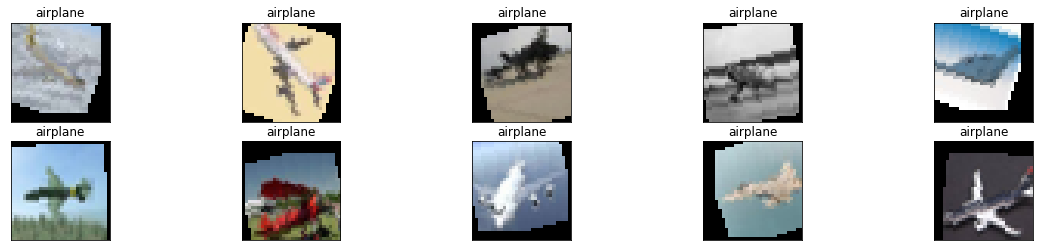

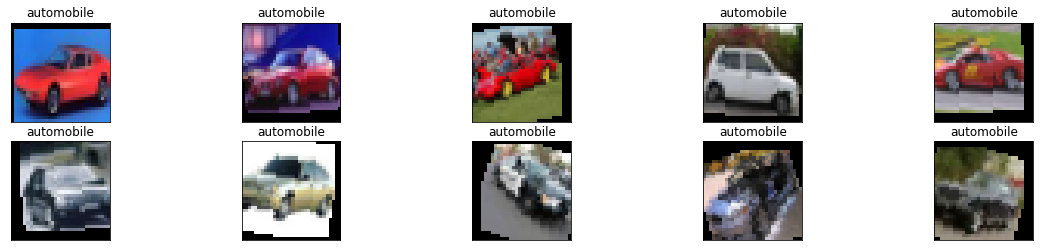

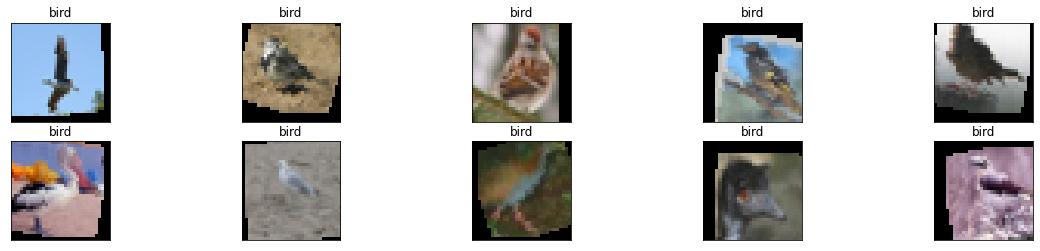

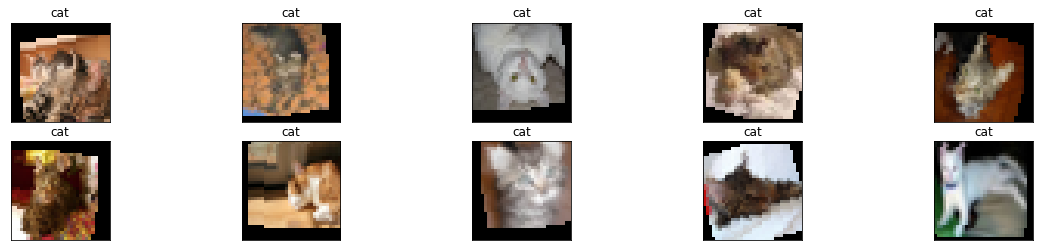

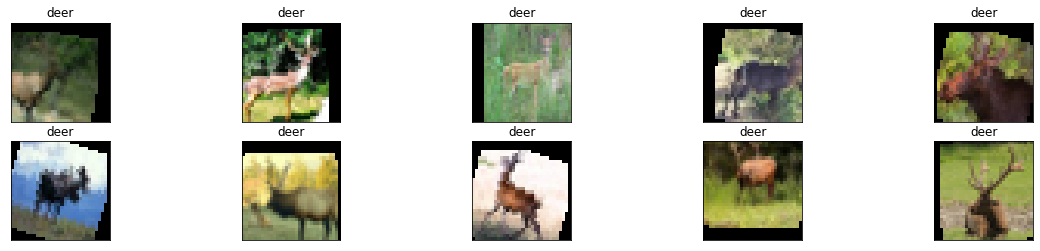

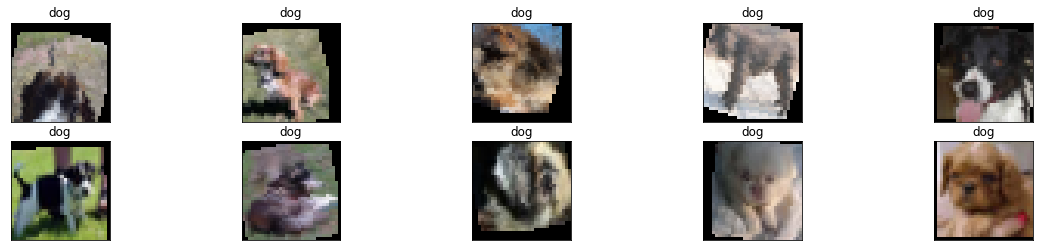

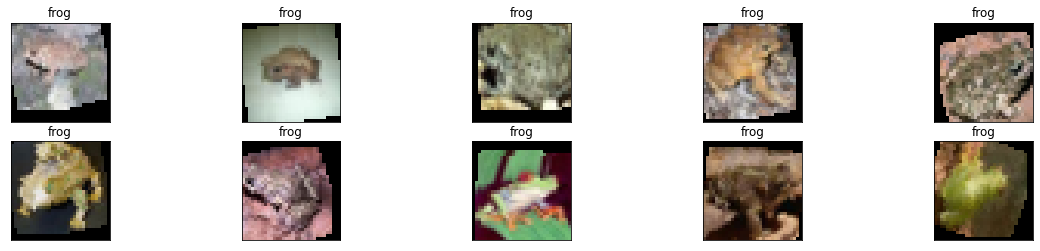

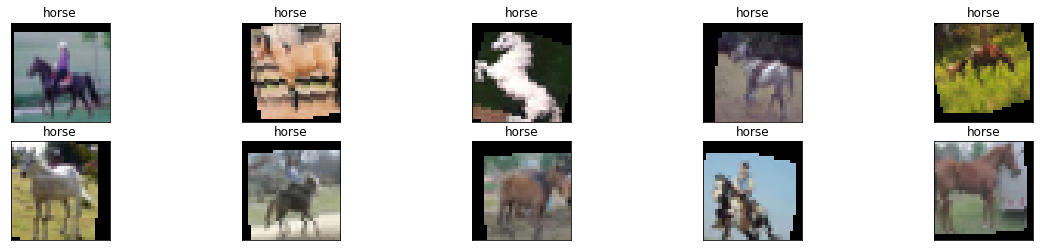

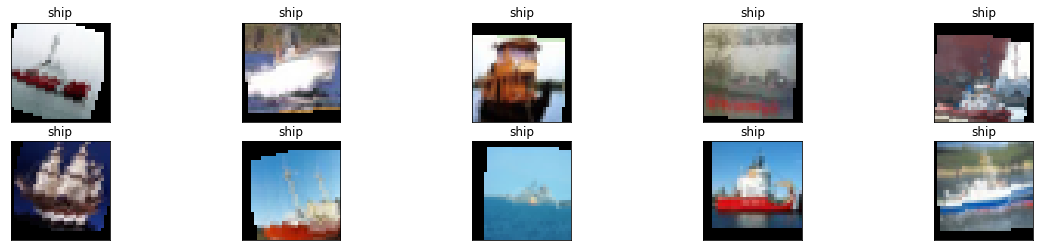

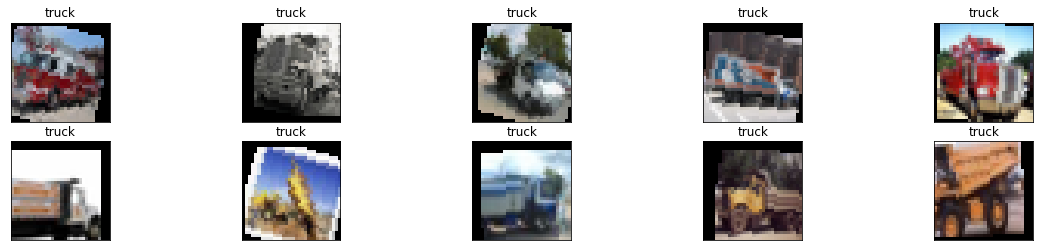

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# функция для показа изображения

def imshow(img, name):
  fig = plt.figure(figsize=(20, 4))
  plot_size=10
  for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    npimg = img[idx].numpy()
    plt.title(name)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# получаем несколько случайных тренировочных изображений (блок 256)
dataiter = iter(train_loader)
images, labels = dataiter.next()

# первые 10 картинок из каждого кластера
for j in range (0, 10):
  list_num = []
  for i in range (0, 256):
    if labels[i] == j:
      list_num.append(i)
      if len(list_num) == 10:
        img = [images[list_num[0]], images[list_num[1]], images[list_num[2]], images[list_num[3]], images[list_num[4]],
               images[list_num[5]], images[list_num[6]], images[list_num[7]], images[list_num[8]], images[list_num[9]]]
        imshow(img, str(classes[j]))
        break


*Определяем сверточную нейронную сеть (CNN)

---


метод Conv2d создает набор сверточных фильтров. (c, h, w): первый аргумент (с - глубина) — количество входных каналов (у нас 3-канальные цветные изображения). Второй аргумент (h - высота, w - ширина) — количество выходных каналов (определяем сами). kernel_size=3 — размер окна с помощью которого сверточный слой анализирует изображение. padding=1 - рисунок дополняется на один пиксель нулями по краям. stride — на сколько смещается ядро на каждом шаге при вычислении следующего пикселя результирующего изображения. Обычно его принимают равным 1, и чем больше его значение, тем меньше размер выходного изображения*

---

простая ReLU функция активации 

---

MaxPool2d. Первый аргумент (kernel_size) — размер объединения, который равен 2х2. Во втором аргументе (stride) указывается размер подвыборки (уменьшение эффективного размера изображения с факторов 2). Следовательно, шаговый аргумент равен 2.

In [45]:
class Flatten(nn.Module):  # как я понимаю, уже реализовано в Sequential
    def forward(self, input):
        return input.view(input.size(0), -1) # изменение формы тензора

In [46]:
model = nn.Sequential(

    # 1 слой (b =256, 3, 32, 32)

    nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size=3, stride=1, padding=1),   # cвертка с 3 каналами размером (32х32) 
    nn.BatchNorm2d(32),                                                                  # нормализация, совпадает с out_channels
    nn.ReLU(),                                                                           # функция активации ReLU
    nn.MaxPool2d(kernel_size=2, stride=2),                                               # пулинга на 2
  
    # 2 слой (b, 32, 16, 16)

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # 3 слой (b, 64, 8, 8)

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # 4 слой (b, 128, 4, 4)

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # (b, 256, 2, 2) forward
    Flatten(),

    # (b, 256*2*2)

    nn.Dropout(p=0.5), # каждый элемент обнуляется в вероятностью 0.5. борьба с переобучением
    nn.Linear(in_features = (2 * 2 * 256), out_features = num_classes) # простой линейный слой

).to(device)


In [47]:
print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, stri

*Определяем функцию потерь и оптимизатор*

In [48]:
# функция потерь
loss_function = nn.CrossEntropyLoss()
# оптимизатор
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)


*Тренировка сети.
Для тренировки сети нам просто нужно пройти цикл нашего итератора данных и передать вводные данные в сеть и оптимизировать.*

In [49]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Place training batch onto the appropriate device
        images = images.to(device)
        labels = labels.to(device)

        # Прямой запуск
        outputs = model(images)
        loss = loss_function(outputs, labels)

        # Обратное распространение и оптимизатор
        optimizer.zero_grad() # обнуляем параметр gradients
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/60], Step [100/196], Loss: 1.4899
Epoch [2/60], Step [100/196], Loss: 1.2766
Epoch [3/60], Step [100/196], Loss: 1.0940
Epoch [4/60], Step [100/196], Loss: 0.9365
Epoch [5/60], Step [100/196], Loss: 0.9535
Epoch [6/60], Step [100/196], Loss: 0.8918
Epoch [7/60], Step [100/196], Loss: 0.8544
Epoch [8/60], Step [100/196], Loss: 0.7378
Epoch [9/60], Step [100/196], Loss: 0.8776
Epoch [10/60], Step [100/196], Loss: 0.7860
Epoch [11/60], Step [100/196], Loss: 0.7078
Epoch [12/60], Step [100/196], Loss: 0.6521
Epoch [13/60], Step [100/196], Loss: 0.6510
Epoch [14/60], Step [100/196], Loss: 0.7174
Epoch [15/60], Step [100/196], Loss: 0.7209
Epoch [16/60], Step [100/196], Loss: 0.8036
Epoch [17/60], Step [100/196], Loss: 0.5555
Epoch [18/60], Step [100/196], Loss: 0.7394
Epoch [19/60], Step [100/196], Loss: 0.7799
Epoch [20/60], Step [100/196], Loss: 0.6482
Epoch [21/60], Step [100/196], Loss: 0.6467
Epoch [22/60], Step [100/196], Loss: 0.6414
Epoch [23/60], Step [100/196], Loss: 0.56

*Тестируем сеть с помощью тестовых данных*

In [50]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_loader), 100 * correct / total))

Test Accuracy of the model on the 40 test images: 80.71 %


In [51]:
# вывод визального результата
import matplotlib.pyplot as plt

import torch
def visualize_model(model, device, dataloader, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    plt.ion()
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        plt.interactive(True)


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
visualize_model(model, device, test_loader, num_images=15,class_names=classes )
matplotlib.pyplot.waitforbuttonpress()

Результаты:
1. **Без** нормализации данных. оптимизатор **SGD**, **50 итераций**  **падинг 4**- 
Test Accuracy of the model on the 40 test images: **77.32 % **

# 2. **Без** нормализации данных. оптимизатор **Adam**, **50 итераций** - Test Accuracy of the model on the 40 test images: **84.1 %**

3. **Нормализации данных** (2). оптимизатор **Adam**, **50 итераций** - 
Test Accuracy of the model on the 40 test images: **24.87 %**

4. **Нормализации данных** (1). оптимизатор **SGD**,**50 итераций** -
Test Accuracy of the model on the 40 test images: **66.1 %**

5. Без нормализации данных. оптимизатор **Adam**, **60 итераций**, **поворот на 20 градусов**, уменьшение **падинга до 2** - Test Accuracy of the model on the 40 test images: **82.5 %**

6. Без нормализации данных. оптимизатор **Adam**, **60 итераций**, **поворот на 20 градусов**, **падинг 4** - Test Accuracy of the model on the 40 test images: 80.71 %
